# Plot results

After experiment, let's plot the result!

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

font = {'family' : 'consolas',
        'weight' : 'light',
        'size'   : 12}

matplotlib.rc('font', **font)
ggplot_colors = [plt.rcParams['axes.color_cycle'][i] for i in [0, 1, 2, 3, 4, 5, 6]]

import os
import sys
import numpy as np
import librosa
import time
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
import logging
import cPickle as cP
import pdb

/misc/kcgscratch1/ChoGroup/keunwoo/venv_k110/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


YOU ARE IN WEAVER in NYU


Using Theano backend.


In [2]:
FOLDER_CSV = 'data_csv/'
FOLDER_FEATS = 'data_feats/'
FOLDER_RESULTS = 'result_transfer/'

In [3]:
def get_one_result(taskname, featname):
    try:
        result = np.load(os.path.join(FOLDER_RESULTS,
                         'T_{}_F_{}_CL_{}.npy'.format(taskname, featname, 'SVC')))
    except:
        try:
            result = np.load(os.path.join(FOLDER_RESULTS,
                         'T_{}_F_{}_CL_{}.npy'.format(taskname, featname, 'SVR')))
        except:
            result = 0.
    return result

def get_one_result_nomatterCLF(taskname, layer):
    try:
        result = np.load(os.path.join(FOLDER_RESULTS,
                         'T_{}_F_{}_CL_{}.npy'.format(taskname, 'mine_{}'.format(layer), 'SVC')))
    except:
        try:
            result = np.load(os.path.join(FOLDER_RESULTS,
                         'T_{}_F_{}_CL_{}.npy'.format(taskname, 'mine_{}'.format(layer), 'SVR')))
        except:
            result = 0.
    return result

def mid_layers_to_str(mid_layers):
    return ''.join([str(i) for i in mid_layers])
    
def my_featname_w_layer(mid_layers):
    return 'mine_' + mid_layers_to_str(mid_layers)


def get_result_all_mine(tasknames, layers):
    results_all = []
    for taskname in tasknames:
        task_results = []
        for layer in layers:
            layer = mid_layers_to_str(layer)
            task_results.append(get_one_result_nomatterCLF(taskname, layer))
        results_all.append(task_results)
    return np.array(results_all)
    

In [4]:
# vars to plot
one_layers = [[i] for i in range(5)]
two_layers = [[i, j] for i in range(5) for j in range(i + 1, 5)]
three_layers = [[i, j, k] for i in range(5) for j in range(i + 1, 5) for k in range(j + 1, 5)]
four_layers = [range(4), range(1, 5)]
five_layers = [range(5)]
all_layers = five_layers + four_layers + three_layers + two_layers + one_layers

tasks = ['T1\nballroom\ngenre\n(acc)', 
         'T2\ngtzan\ngenre\n(acc)', 
         'T3\ngtzan\nspeech/music\n(acc)', 
         'T4a\nemotion\n(arousal)\n(r^2)', 
         'T4v\nemotion\n(valence)\n(r^2)',          
         'T5\nvocal\nnon-vocal\n(acc)',
         'T6\naudio\nevent\n(acc)']
tasknames = ['ballroom_extended', 'gtzan_genre', 'gtzan_speechmusic',
              'emoMusic_a', 'emoMusic_v', 'jamendo_vd', 'urbansound']

titles = ['Extended Ballroom', 'Gtzan music genre', 'Gtzan speech/music',
         'Music emotion (arousal)', 'Music emotion (valence)', 'Vocal/non-vocal', 'Acoustic event']

taskidxs = ['T1', 'T2', 'T3', 'T4a', 'T4b', 'T5', 'T6']

clfnames = ['SVC', 'SVC', 'SVC', 'SVR', 'SVR', 'SVC', 'SVC']

all_layers_str = [mid_layers_to_str(mid_layer) for mid_layer in all_layers]
all_feature_names = [my_featname_w_layer(mid_layer) for mid_layer in all_layers]
sotas_list = [0.949, .945, 1.0, 0.704, 0.500, 0., 0.79]
mfcc_12345s_list = [get_one_result(t, 'mfcc+12345_4') for t in tasknames]
mfcc_12345s = {key:val for key, val in zip(tasknames, mfcc_12345s_list)}
sotas = {key:val for key, val in zip(tasknames, sotas_list)}

In [5]:
def _score_to_str(score, str_format='%0.3f'):
    if score == 1.0:
        return '1.'
    if score == 0.0:
        return ''
    st = str_format % score
    return st[1:]

In [6]:
def plot_one_task(taskname, classifiername, title):
    
    results = []
    for featname in all_feature_names:
        results.append(get_one_result(taskname, featname))
    # find max 
    max_idx = np.argmax(results)
    # load mfcc score if exists
    mfcc_score = get_one_result(taskname, 'mfcc_4')
    sota_score = sotas[taskname]
    mfcc_12345_score = mfcc_12345s[taskname]
    # find top-K
    top_k = 7
    down_k = 7
    top_idxs = np.flipud(np.argsort(results))
    
    # plot
    num_type_convnet = len(results)
    xs_convnet = range(num_type_convnet)

    xs = range(len(results) + 3)

    plt.figure(figsize=(10, 2.5))
    # plot bar - my feature
    plt.bar(xs_convnet, results, label='Convnet', color=ggplot_colors[1])
    # plot bar - etc
    plt.bar(num_type_convnet, mfcc_12345_score, label='MFCCs+\n12345', color='#668CCA')
    plt.bar(num_type_convnet + 1, mfcc_score, label='MFCCs', color=ggplot_colors[2])
    plt.bar(num_type_convnet + 2, sota_score, label='SoTA', color=ggplot_colors[0])
    
    # xtick
    all_layers_str_xtick = [s.replace('4','5').replace('3','4').replace('2','3').replace('1','2').replace('0','1') for \
                     s in all_layers_str]
    plt.xticks([i+0.7 for i in xs], all_layers_str_xtick + ['concat', 'mfcc', 'SoTA'], rotation=70,
              horizontalalignment='right')
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.ylim(0, 1)
    plt.xlim(0, len(xs))
    if taskname.startswith('emo'):
        plt.ylabel('$r^2$ score')
    else:
        plt.ylabel('Accuracy')
    # texts
    max_score = results[max_idx]
    plt.text(max_idx + 0.4, results[max_idx], _score_to_str(np.round(max_score, decimals=4)),
            horizontalalignment='center', verticalalignment='bottom')

    plt.text(num_type_convnet + 0.4, mfcc_12345_score, _score_to_str(np.round(mfcc_12345_score, decimals=4)),
            horizontalalignment='center', verticalalignment='bottom')
    
    plt.text(num_type_convnet + 1 + 0.4, mfcc_score, _score_to_str(np.round(mfcc_score, decimals=4)),
            horizontalalignment='center', verticalalignment='bottom')
    
    plt.text(num_type_convnet + 2 + 0.4, sota_score, _score_to_str(np.round(sota_score, decimals=4)),
            horizontalalignment='center', verticalalignment='bottom')
    # texts - ranking
    for ranking, idx in enumerate(top_idxs):
        if ranking < top_k or ranking >= num_type_convnet - down_k:
            tcolor = 'white'
        else:
            tcolor = '0.7'
        plt.text(idx + 0.4, max_score - 0.03 - 0.8 * ranking / float(num_type_convnet) * max_score , str(ranking + 1),
                    horizontalalignment='center', verticalalignment='top', color=tcolor)
    plt.title(title)
    plt.tight_layout()

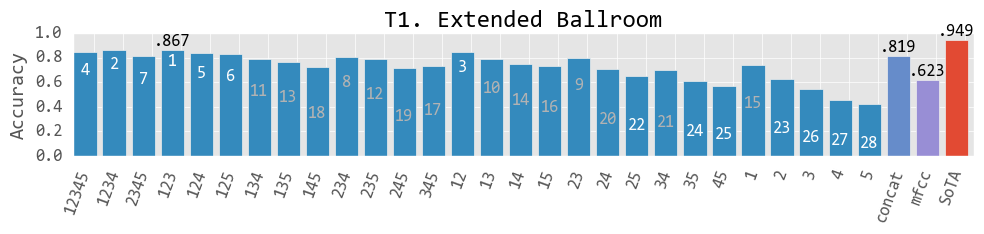

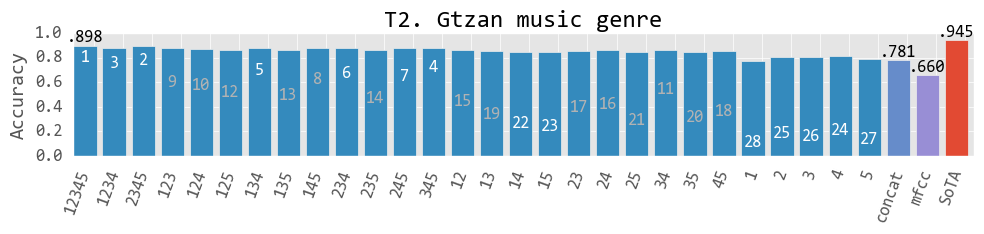

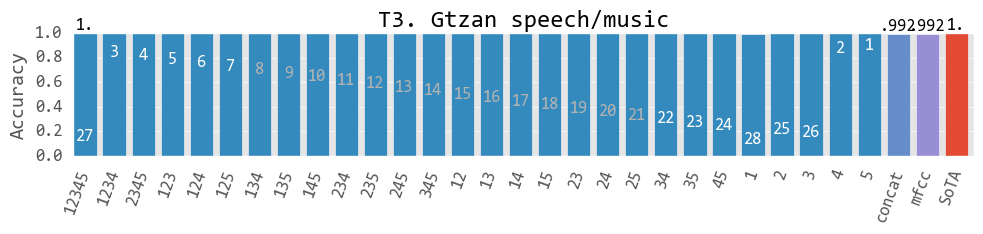

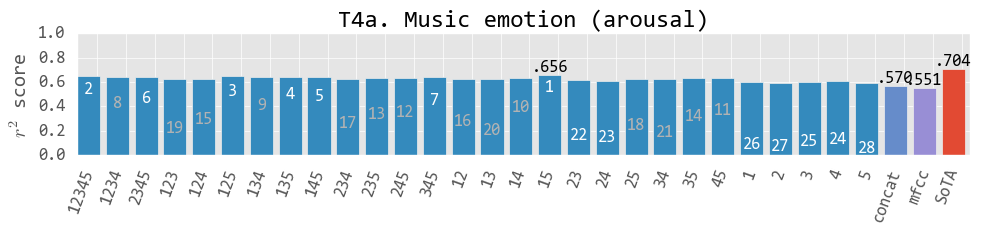

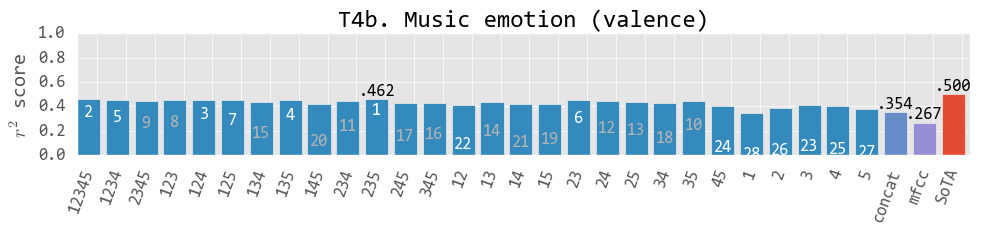

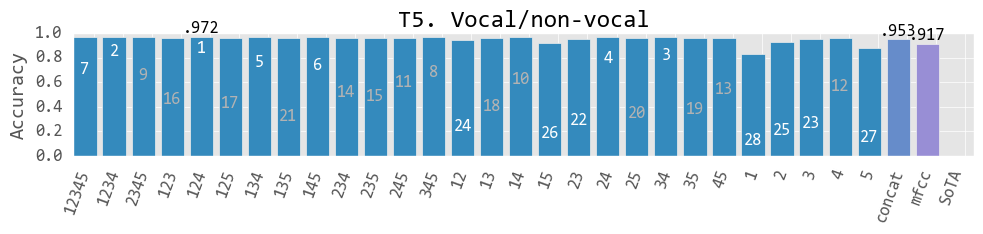

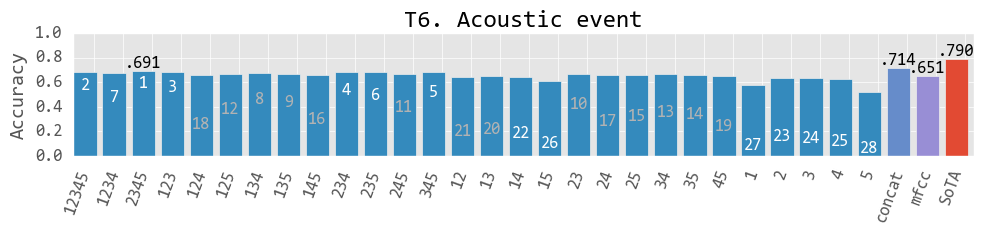

In [7]:
for task_idx, taskname, clfname, title in zip(taskidxs, tasknames, clfnames, titles):
    plot_one_task(taskname, clfname, '{}. {}'.format(task_idx, title))
    plt.savefig('figs/fig_feature_performances_per_layers_{}.pdf'.format(taskname))

In [8]:
def plot_compare_results(me, concat, mf, st, xticks, title, ylabel=''):
    
    num_items = 4
    gaps = num_items + 1
    plt.bar(np.arange(0, len(me)*gaps, gaps), me, color=ggplot_colors[1], label='Best of\npre-trained',
           alpha=1)
    plt.bar(np.arange(1, len(me)*gaps, gaps), concat, color='#668CCA', label="Concatenating\n12345 + MFCCs",
           alpha=1)    
    plt.bar(np.arange(2, len(me)*gaps, gaps), mf, color=ggplot_colors[2], label='MFCCs',
           alpha=1)
    plt.bar(np.arange(3, len(me)*gaps, gaps), st, color=ggplot_colors[0], label='SoTA',
           alpha=1)
    
    fsize = 11
    min_gap_y = 0.07
    max_y = 1.0
    for i, (x, y_me, y_concat, y_mf, y_st) in enumerate(zip(np.arange(0, len(me)*gaps, gaps), me, concat, mf, st)):
        y1 = np.min((y_me, max_y))
        if i == 6:
            y1 -= 0.06
        plt.text(x+0.5, y1, _score_to_str(y_me), ha='center', va='bottom',
                size=fsize)
        
        y2 = np.min((y_concat, max_y))
        if i == 2 or i == 5:
            y2 -= 0.065
        plt.text(x+1.5, y2, _score_to_str(y_concat), ha='center', va='bottom',
                size=fsize, color='0.2')

        y3 = np.min((y_mf, max_y))
        if i == 5:
            y3 += 0.02
        plt.text(x+2.5, y3, _score_to_str(y_mf), ha='center', va='bottom',
                size=fsize)
        
        y4 = np.min((y_st, max_y))
        if i == 2:
            y4 -= 0.1        
        plt.text(x+3.5, y4, _score_to_str(y_st), ha='center', va='bottom',
                size=fsize, color='0.2')
        
    plt.xticks(np.arange(1.4, len(me)*gaps, gaps), xticks)
    plt.legend(loc='lower right', prop={'size':13})
    plt.title(title)
    plt.xlim([0, len(me)*gaps + 12])
    plt.ylim([0, 1])
    plt.ylabel(ylabel)
    plt.tight_layout()

# usage:
# me = [0.352, 0.714, 0.992, 0.572, 0.303, 0.865, 0.442]
# mf = [0.476, 0.507, 0.93, 0.523, 0.146, 0.814, 0.490 ]

# plot_results(me, mf, tasks, '')

In [9]:
me = get_result_all_mine(tasknames, all_layers)
me = me.max(axis=1)
print me
print mfcc_12345s_list

[ 0.86674641  0.898       1.          0.65624685  0.46196466  0.9717682
  0.69079249]
[array(0.8186602870813398), array(0.781), array(0.9921875), array(0.5701254288215712), array(0.3535756734310506), array(0.9524517087667161), array(0.7138112688960147)]


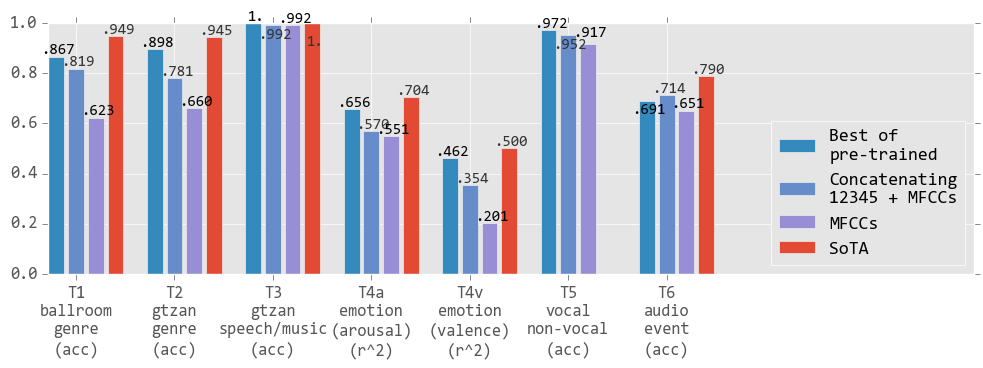

In [11]:
# with gamma grid search, picking best of (non_stdd, stdd)
mf = [.623, .660, .992, .551, .201, .917, .651]
st = sotas_list
plt.figure(figsize=(10, 3.7))
plot_compare_results(me, mfcc_12345s_list, mf, st, tasks, '')
plt.savefig('figs/fig_feature_performances_all_svm_gamma_search_best_stdd.pdf')
plt.savefig('figs/fig_feature_performances_all_svm_gamma_search_best_stdd.png')

# Per-label accuracy


for gtzan music

In [43]:
import utils_featext

def load_xy_many(taskname, featname='mine', npy_suffix='', logger=None, mid_layer=4):
    """ wrapper for load_xy() for loading and concatenating multiple of them. """
    if featname == 'mfcc':
        x, y = load_xy(taskname, featname, npy_suffix, logger, mid_layer=mid_layer)
    elif featname == 'mine':
        for l_idx, mid_layer_num in enumerate(mid_layer):
            if l_idx == 0:
                x, y = load_xy(taskname, featname, npy_suffix, logger, mid_layer=mid_layer_num)
            else:
                x_new, _ = load_xy(taskname, featname, npy_suffix, logger, mid_layer=mid_layer_num)
                x = np.concatenate((x, x_new), axis=1)
    return x, y

def load_xy(task_name, feat_name='mine', npy_suffix='', logger=None, mid_layer=4):
    """

    :param task_name:
    :param feat_name:
    :param npy_suffix:
    :param logger:
    :param mid_layer: ignired if 'mfcc' is used
    :return:
    """
    assert task_name in ('ballroom_extended', 'gtzan_genre', 'gtzan_speechmusic',
                         'emoMusic_a', 'emoMusic_v', 'jamendo_vd', 'urbansound')
    # logger.info('load_xy({}, {}, mid_layer: {}, npy_suffix: {})...'.format(task_name, feat_name, mid_layer, npy_suffix))

    # X
    csv_filename = '{}.csv'.format(task_name)
    if feat_name == 'mine':
        if task_name.startswith('emoMusic'):
            if mid_layer == 4:  # For the last layer, use Max-Pooled one
                npy_filename = '{}{}.npy'.format('emoMusic', npy_suffix)
            else:  # For the others, use Average-Pooled ones
                npy_filename = '{}_layer_{}{}.npy'.format('emoMusic', mid_layer, npy_suffix)
        else:
            if mid_layer == 4:
                npy_filename = '{}{}.npy'.format(task_name, npy_suffix)
            else:
                npy_filename = '{}_layer_{}{}.npy'.format(task_name, mid_layer, npy_suffix)
    elif feat_name == 'mfcc':
        if task_name.startswith('emoMusic'):
            npy_filename = '{}_mfcc.npy'.format('emoMusic')
        else:
            npy_filename = '{}_mfcc.npy'.format(task_name)

    x = np.load(os.path.join(FOLDER_FEATS, npy_filename))
    # Y
    if task_name == 'emoMusic_v':
        csv_filename = '{}.csv'.format('emoMusic')
        df = pd.DataFrame.from_csv(os.path.join(FOLDER_CSV, csv_filename))
        y = df['label_valence']
    elif task_name == 'emoMusic_a':
        csv_filename = '{}.csv'.format('emoMusic')
        df = pd.DataFrame.from_csv(os.path.join(FOLDER_CSV, csv_filename))
        y = df['label_arousal']
    else:
        y = pd.DataFrame.from_csv(os.path.join(FOLDER_CSV, csv_filename))['label']
    return x, y

In [172]:
scores = []

# last layer only
svc = SVC(gamma=0.125, C=8.0, kernel='rbf')
x, y = load_xy_many('gtzan_genre', 'mine', '', None, [4])
sts = StandardScaler()
x = sts.fit_transform(x)
scores.append(cross_val_score(svc, x, y, cv=10))

# all layers
svc = SVC(gamma='auto', C=32.0, kernel='rbf')
x, y = load_xy_many('gtzan_genre', 'mine', '', None, [0,1,2,3,4])
sts = StandardScaler()
x = sts.fit_transform(x)
scores.append(cross_val_score(svc, x, y, cv=10))
print np.array(scores).mean(axis=1)

[ 0.755  0.875]


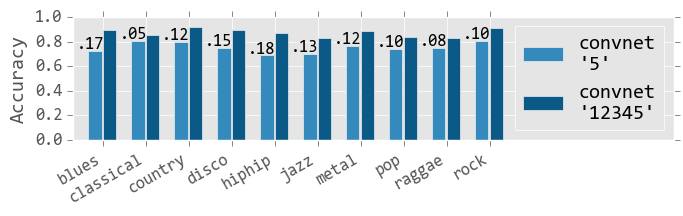

In [188]:
n_sys = len(scores)
n_genre = 10
xss = []
colors = ['#348ABD', '#0B5987']
plt.figure(figsize=(7, 2.3))
labels = ["convnet\n'5'", "convnet\n'12345'"]
margin = 0.9
width = 0.9
xticks = np.arange(n_sys/2., (n_sys+margin) * n_genre, n_sys+margin)
xtickslabels = ['blues', 'classical', 'country', 'disco', 'hiphip',
          'jazz', 'metal', 'pop', 'raggae', 'rock']
for i in range(n_sys):
    xss.append(np.arange(i, (n_sys+margin)*n_genre + i, n_sys+margin))
    plt.bar(xss[i], scores[i], color=colors[i], label=labels[i], width=width)

for x, score1, score2 in zip(xss[0], scores[0], scores[1]):
    plt.text(x-0.8, score1+0.02, _score_to_str(score2 - score1, str_format='%0.2f'))


plt.xticks(xticks, xtickslabels, rotation=30, horizontalalignment='right')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.xlim([-1,(margin+n_sys) * n_genre + 10.5])

plt.savefig('figs/fig_gtzan_result_per_genre.pdf')